# Statistics in `cytoflow`

One of the most powerful concepts in `cytoflow` is that it makes it easy to summarize subsets of your data, then track how those subsets change as your experimental variables change.  This notebook demonstrates several different modules that create and plot statistics.

---

Set up the Jupyter `matplotlib` integration, and import the `cytoflow` module.

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import cytoflow as flow

We use the same data set as the **Yeast Dose Response** example notebook, with one variant: we load each tube three times, grabbing only 100 events from each.

In [2]:
inputs = {
    "Yeast_B1_B01.fcs" : 5.0,
    "Yeast_B2_B02.fcs" : 3.75,
    "Yeast_B3_B03.fcs" : 2.8125,
    "Yeast_B4_B04.fcs" : 2.109,
    "Yeast_B5_B05.fcs" : 1.5820,
    "Yeast_B6_B06.fcs" : 1.1865,
    "Yeast_B7_B07.fcs" : 0.8899,
    "Yeast_B8_B08.fcs" : 0.6674,
    "Yeast_B9_B09.fcs" : 0.5,
    "Yeast_B10_B10.fcs" : 0.3754,
    "Yeast_B11_B11.fcs" : 0.2816,
    "Yeast_B12_B12.fcs" : 0.2112,
    "Yeast_C1_C01.fcs" : 0.1584,
    "Yeast_C2_C02.fcs" : 0.1188,
    "Yeast_C3_C03.fcs" : 0.0892,
    "Yeast_C4_C04.fcs" : 0.0668,
    "Yeast_C5_C05.fcs" : 0.05,
    "Yeast_C6_C06.fcs" : 0.0376,
    "Yeast_C7_C07.fcs" : 0.0282,
    "Yeast_C8_C08.fcs" : 0.0211,
    "Yeast_C9_C09.fcs" : 0.0159
}

tubes = []
for filename, ip in inputs.iteritems():
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 1}))
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 2}))
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 3}))

    
ex = flow.ImportOp(conditions = {'IP' : "float", "Replicate" : "int"},
                   tubes = tubes,
                   coarse_events = 100).apply()

In `cytoflow`, a *statistic* is a value that summarizes something about a subset of the data.  For example, if we expect the geometric mean of `FITC-A` channel to change as the `IP` variable changes, we can compute those geometric means with the `ChannelStatisticOp` operation:

In [3]:
op = flow.ChannelStatisticOp(name = "ByIP",
                             by = ["IP"],
                             channel = "FITC-A",
                             function = flow.geom_mean)
ex2 = op.apply(ex)

This operation splits the data set by different values of `IP`, then applies the function `flow.geom_mean` to the `FITC-A` channel in each subset.  The result is stored in the `statistics` attribute of the `Experiment` that it returns:

In [4]:
ex2.statistics

{('ByIP', 'geom_mean'): IP
 0.0159     108.404840
 0.0211     150.552289
 0.0282     154.419056
 0.0376     210.314949
 0.0500     281.696596
 0.0668     414.273127
 0.0892     670.282147
 0.1188     932.870526
 0.1584    1236.009013
 0.2112    1132.311499
 0.2816    1518.710287
 0.3754    1777.693899
 0.5000    1767.286636
 0.6674    2180.627029
 0.8899    2261.260167
 1.1865    2419.906843
 1.5820    2529.996642
 2.1090    2505.462012
 2.8125    2440.712572
 3.7500    2463.828409
 5.0000    2345.545861
 dtype: float64}

The `statistics` attribute is a dictionary.  The keys are tuples, where the first element in the tuple is the name of the operation that created the statistic, and the second element is specific to the operation.  The `Statistics1DOp` operation sets the second element of the tuple to the function name.  (You can override this by setting `Statistics1DOp.statistic_name`; this is useful if `function` is a lambda function.)

In [5]:
ex2.statistics.keys()

[('ByIP', 'geom_mean')]

The value of each entry in `Experiment.statistics` is a `pandas.Series`.  The series index is all the subsets for which the statistic was computed, and the contents are the values of the statstic itself.

In [6]:
ex2.statistics[('ByIP', 'geom_mean')]

IP
0.0159     108.404840
0.0211     150.552289
0.0282     154.419056
0.0376     210.314949
0.0500     281.696596
0.0668     414.273127
0.0892     670.282147
0.1188     932.870526
0.1584    1236.009013
0.2112    1132.311499
0.2816    1518.710287
0.3754    1777.693899
0.5000    1767.286636
0.6674    2180.627029
0.8899    2261.260167
1.1865    2419.906843
1.5820    2529.996642
2.1090    2505.462012
2.8125    2440.712572
3.7500    2463.828409
5.0000    2345.545861
dtype: float64

We can also specify multiple variables to break data set into.  In the example above, `Statistics1DOp` lumps all events with the same value of `IP` together, but each amount of `IP` actually has three values of `Replicate` as well.  Let's apply `geom_mean` to each unique combination of `IP` and `Replicate`:

In [7]:
op = flow.ChannelStatisticOp(name = "ByIP",
                             by = ["IP", "Replicate"],
                             channel = "FITC-A",
                             function = flow.geom_mean)
ex2 = op.apply(ex)
ex2.statistics[("ByIP", "geom_mean")][0:12]

IP      Replicate
0.0159  1            113.984158
        2            101.996895
        3            109.575779
0.0211  1            145.527138
        2            155.963229
        3            150.351320
0.0282  1            155.810010
        2            149.928289
        3            157.624506
0.0376  1            208.115497
        2            211.246862
        3            211.600038
dtype: float64

Note that the `pandas.Series` now has a `MultiIndex`: there are values for each unique combination of `IP` and `Replicate`.

---

Now that we have computed a statistic, we can plot it with one of the statistics views.  We can use a bar chart:

In [8]:
flow.BarChartView(statistic = ("ByIP", "geom_mean"),
                  variable = "IP").plot(ex2)

CytoflowViewError: Must use all the statistic indices as variables or facets: [u'IP', u'Replicate']

Oops!  Whenever we plot a statistic, we have to use *all* of the variables that were used to subdivide the experiment.  If the `Statistics1DOp` above had `by = ["IP", "Replicate"]`, then both `IP` and `Replicate` must either a plot variable or a plot facet.  Let's try it again:

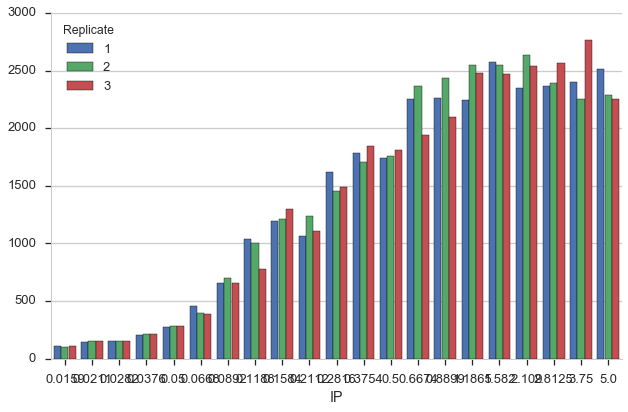

In [9]:
flow.BarChartView(statistic = ("ByIP", "geom_mean"),
                  variable = "IP",
                  huefacet = "Replicate").plot(ex2)

Bar charts are really best for categorical variables (with a modest number of categories.)  Let's do a line chart instead:

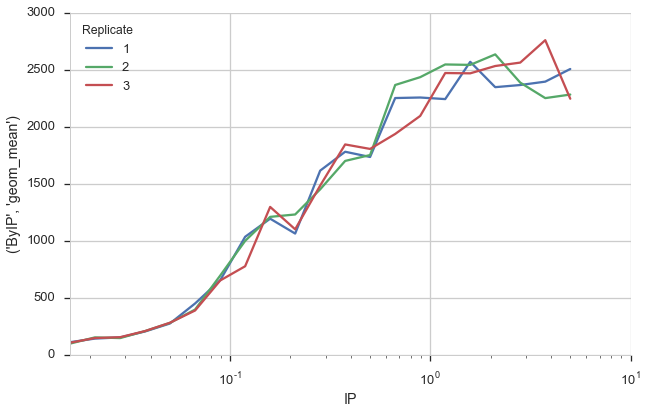

In [10]:
flow.Stats1DView(statistic = ("ByIP", "geom_mean"),
                 xvariable = "IP",
                 xscale = 'log',
                 huefacet = "Replicate").plot(ex2)

Statistics views can also plot error bars; the error bars must *also* be a statistic, and they must have the same indices as the "main" statistic.  For example, let's plot the geometric mean and geometric standard deviation of each IP subset:

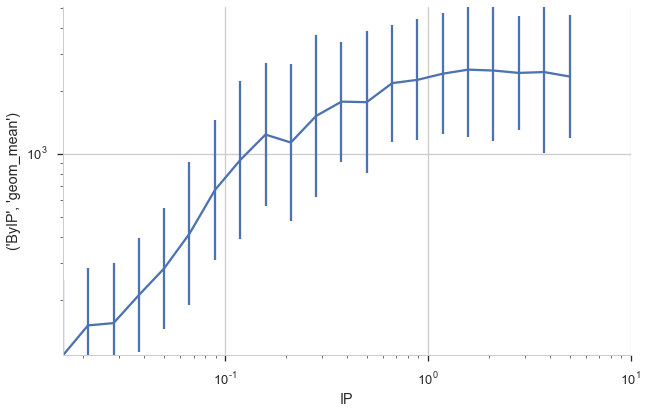

In [11]:
ex2 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ["IP"],
                              channel = "FITC-A",
                              function = flow.geom_mean).apply(ex)

ex3 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ['IP'],
                              channel = "FITC-A",
                              function = flow.geom_sd_range).apply(ex2)

flow.Stats1DView(statistic = ("ByIP", "geom_mean"),
                 xvariable = "IP",
                 xscale = "log",
                 yscale = "log",
                 error_statistic = ("ByIP", "geom_sd_range")).plot(ex3)

The plot above shows how one statistic varies (on the Y axis) as a variable changes on the X axis.  We can also plot two statistics against eachother.  For example, we can ask if the geometric standard deviation varies as the geometric mean changes:

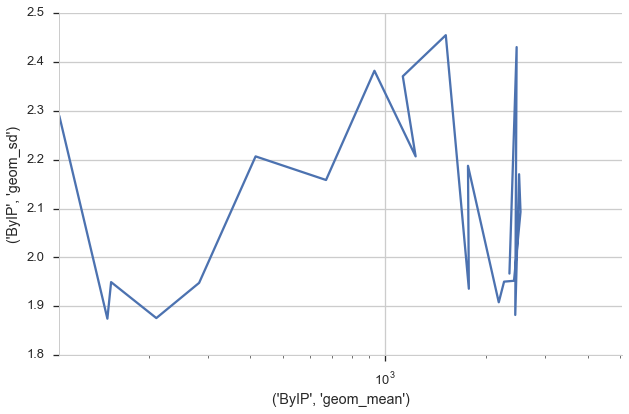

In [12]:
ex2 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ["IP"],
                              channel = "FITC-A",
                              function = flow.geom_mean).apply(ex)

ex3 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ['IP'],
                              channel = "FITC-A",
                              function = flow.geom_sd).apply(ex2)

flow.Stats2DView(variable = "IP",
                 xstatistic = ("ByIP", "geom_mean"),
                 ystatistic = ("ByIP", "geom_sd"),
                 xscale = "log").plot(ex3)

Nope, guess not.  See the **TASBE Calibrated Flow Cytometry** notebook for more examples of 1D and 2D statistics views.

---

In addition to making statistics by applying summary functions to data, you can also apply functions to other statistics.  For example, a common question is "What percentage of my events are in a particular gate?"  We could, for instance, ask what percentage of events are above 1000 in the `FITC-A` channel, and how that varies by amount of `IP`. We start by defining a *threshold* gate with `ThresholdOp`:

In [13]:
thresh = flow.ThresholdOp(name = "Above1000",
                          channel = "FITC-A",
                          threshold = 1000)
ex2 = thresh.apply(ex)

Next, we compute the total number of events in each subset with a unique combination of `Above1000` and `IP`:

In [66]:
import numpy as np

ex3 = flow.ChannelStatisticOp(name = "Above1000",
                              by = ["Above1000", "IP"],
                              channel = "FITC-A",
                              function = len).apply(ex2)
print ex3.statistics[("Above1000", "len")]
#stat = ex3.statistics[("Above1000", "len")]

#stat.reindex(stat.index, fill_value = 0)
#print [ex2.data[x].unique() for x in ["Above1000", "IP"] ]

Above1000  IP    
False      0.0159    300
           0.0211    300
           0.0282    300
           0.0376    296
           0.0500    293
           0.0668    263
           0.0892    196
           0.1188    144
           0.1584     98
           0.2112    103
           0.2816     69
           0.3754     50
           0.5000     53
           0.6674     28
           0.8899     25
           1.1865     20
           1.5820     26
           2.1090     23
           2.8125     26
           3.7500     19
           5.0000     28
True       0.0376      4
           0.0500      7
           0.0668     37
           0.0892    104
           0.1188    156
           0.1584    202
           0.2112    197
           0.2816    231
           0.3754    250
           0.5000    247
           0.6674    272
           0.8899    275
           1.1865    280
           1.5820    274
           2.1090    277
           2.8125    274
           3.7500    281
           5.0000    272
dtype: 

And now we compute the percentage of `Above1000 == True` and `Above1000 == False` for each value of `IP`:

In [71]:
import pandas as pd
ex4 = flow.TransformStatisticOp(name = "Above1000",
                                statistic = ("Above1000", "len"),
                                by = ["IP"],
                                function = lambda a: pd.Series(a / a.sum()),
                                statistic_name = "percent").apply(ex3)
ex4.statistics[("Above1000", "percent")]

  Above1000      IP    0
0     False  0.0159  300
0    1.0
Name: 0, dtype: float64
  Above1000      IP    0
1     False  0.0211  300
1    1.0
Name: 0, dtype: float64
  Above1000      IP    0
2     False  0.0282  300
2    1.0
Name: 0, dtype: float64
   Above1000      IP    0
3      False  0.0376  296
21      True  0.0376    4
3     0.986667
21    0.013333
Name: 0, dtype: float64
   Above1000    IP    0
4      False  0.05  293
22      True  0.05    7
4     0.976667
22    0.023333
Name: 0, dtype: float64
   Above1000      IP    0
5      False  0.0668  263
23      True  0.0668   37
5     0.876667
23    0.123333
Name: 0, dtype: float64
   Above1000      IP    0
6      False  0.0892  196
24      True  0.0892  104
6     0.653333
24    0.346667
Name: 0, dtype: float64
   Above1000      IP    0
7      False  0.1188  144
25      True  0.1188  156
7     0.48
25    0.52
Name: 0, dtype: float64
   Above1000      IP    0
8      False  0.1584   98
26      True  0.1584  202
8     0.326667
26    0.6733

IP        
0.0159  0     1.000000
0.0211  1     1.000000
0.0282  2     1.000000
0.0376  3     0.986667
        21    0.013333
0.0500  4     0.976667
        22    0.023333
0.0668  5     0.876667
        23    0.123333
0.0892  6     0.653333
        24    0.346667
0.1188  7     0.480000
        25    0.520000
0.1584  8     0.326667
        26    0.673333
0.2112  9     0.343333
        27    0.656667
0.2816  10    0.230000
        28    0.770000
0.3754  11    0.166667
        29    0.833333
0.5000  12    0.176667
        30    0.823333
0.6674  13    0.093333
        31    0.906667
0.8899  14    0.083333
        32    0.916667
1.1865  15    0.066667
        33    0.933333
1.5820  16    0.086667
        34    0.913333
2.1090  17    0.076667
        35    0.923333
2.8125  18    0.086667
        36    0.913333
3.7500  19    0.063333
        37    0.936667
5.0000  20    0.093333
        38    0.906667
Name: 0, dtype: float64

One of the most exciting aspects of statistics in `cytoflow` is that other data-driven modules can add them to an `Experiment`, too.  For example, the `GaussianMixture1DOp` adds several statistics for each component of the mixture model it fits, containing the mean, standard deviation and proportion of observations in each component: